# Sampling
This chapter shows how we can simulate these aggregated Markov processes including a denoising step by using a higher order Hinkley detector {cite}`schultze1993`.
We start by sampling a AMP from ```COCCO```, the linear five state topology from last chapter.
## Sampling processes

In [1]:
import numpy as np
from bonnpatch.core import generation
adj=np.array([[0,0,1,1,0],[0,0,0,0,1],[1,0,0,0,0],[1,0,0,0,1],[0,1,0,1,0]])
n_o=2
top=generation.Topology(adj,n_o,name="COCCO")
sampler=generation.AMPSampler()
Z=sampler.sample_amp(top,min_rate=10**2,max_rate=10**5)

This samples a AMP satisfying detailed balance with rates in the specified range, the values above agree with the assumed values if no rates are specified and with the choice in {cite}`oikonomou2024`. If the process does not need to satisfy detailed balance, one can pass ```detailed_balance=False```.

We can also sample from a random topology by using ```TopologyFamily``` or some custom code. BonnPatch supports the family of linear five state topologies:

In [2]:
Z2=sampler.sample_from_family(generation.LinearFiveStateToplogies()) 

```{note}
The sampler above uses numpys random number generator if no other generator is given.
```
## Sampling paths and observations
In this next example, will will sample some path, add some noise to it and try to remove it using a higher order Hinkley detector.
First we sample a path:

In [5]:
from bonnpatch.core import gillepsie
T = 10
ts, xs = gillepsie.sample_path(Z, T=T)
measured_times = np.arange(start=0, stop=T, step=1 / (10**6))
ts = np.asarray(ts)
xs = np.asarray(xs)
idxs = np.searchsorted(ts, measured_times, side="right") - 1
values_at_measured_times = np.where(idxs >= 0, Z._f(xs[idxs]), np.nan)
measured_values = sampler.add_noise(values_at_measured_times)


Typically both low pass filters and HOHDs are used to filter the measured values back to some signal valued in $\{0,1\}$. We will simulate this using scipys Bessel filter and BonnPatches implementation of higher order Hinkley detectors. For this we choose the implied order of 8 (i.e. 8 sums) and calculate the cutoff parameter. The latter can be done in a couple of ways as we will see later.

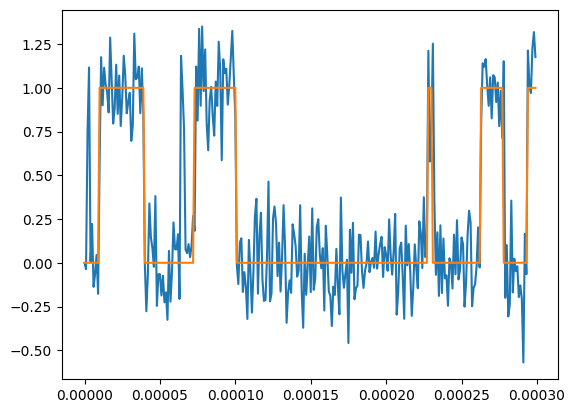

In [10]:
from scipy.signal import bessel, filtfilt
import matplotlib.pyplot as plt
hohd=generation.HigherOrderHinkleyDetector()
hohd.set_cutoff(hohd.calculate_cutoff(t_res=2))
fs = 100_000  # Sampling freq
order = 4
Wn = 10_000
b, a = bessel(order, Wn, btype="low", fs=fs)
ys = np.array(hohd.filter(filtfilt(b, a, measured_values)), np.bool)

plt.plot(measured_times[:300],measured_values[:300],label="Observed values")
plt.plot(measured_times[:300],ys[:300],label="Reconstructed signal")
plt.show()

The performance of th HOHD is primarily dictated by the cutoff parameter, which can be chosen in different ways. BonnPatch supports multiple approaches, namely:
1. ```auto/ simulate```: Calculate the step response of the HOHD over ```t_res``` steps and choose the resulting value as the cutoff parameter. ```auto``` switches between simulating this and calculating this via a direct formula, depending on the choice of the parameters to avoid numerical problems, while ```simulate``` always simulates the response. This is in line with the propsed way of the original Hinkley detector {cite}`hinkley`
2. ```schultze-draber```: method from {cite}`schultze1993`: $\frac{22p}{\text{SNR}^2}$


## Bibliography
```{bibliography}
:style: alpha
:filter: docname in docnames
```